In [1]:
import torch
from torch import argmax, argsort, relu
from torchvision.models import resnet18
from torchsummary import summary
from utils import classify
import cv2
import numpy as np
from matplotlib import pyplot as plt
from captum.attr import LayerLRP, LayerActivation
from copy import deepcopy
import os
from male import get_important_neurons

/home/adamwsl/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.25.9) or chardet (5.1.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
%load_ext autoreload

In [3]:
filename = 'lakeside.jpg'

In [4]:
import torch
from torchvision.models import resnet18
model = resnet18(pretrained=True)
_ = model.eval()
# summary(model, (3, 224, 224))

In [5]:
%autoreload 2
probabilities, top_probabilities, categories, input_batch, input_tensor = classify(filename, model)

In [6]:
image_center_resized = input_tensor.numpy()
image_center_resized = np.transpose(image_center_resized, (1, 2, 0))

In [7]:
import pandas as pd
import os
descriptions = pd.read_csv(os.path.join('milan_results', 'resnet18_imagenet.csv'))
#layer_names = ['conv1'] + ['layer' + str(i) for i in range(1, 5, 1)]
layer_names = ['layer4']
layer_map = {'conv1' : model.bn1, 
             'layer1' : model.layer1[0].bn2, 
             'layer2' : model.layer2[0].bn2, 
             'layer3' : model.layer3[0].bn2, 
             'layer4' : model.layer4[0].bn2}

In [8]:
how_much_highest = 10

In [9]:
per_layer_results, per_layer_activations = get_important_neurons(how_much_highest, 
                                                                 input_batch, 
                                                                 model, 
                                                                 layer_names, 
                                                                 layer_map, 
                                                                 descriptions, 
                                                                 probabilities)

/home/adamwsl/.local/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [10]:
print(categories[0])

lakeside


In [13]:
from utils import wikipedify
wiki_text = wikipedify(categories[0])

In [12]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

tokenized_wiki_text = word_tokenize(wiki_text)
tokenized_wiki_text = [w.lower() for w in tokenized_wiki_text if (not w.lower() in stop_words) and w.lower().isalpha()]

for layer_name, results in per_layer_results.items():
    for unit_id, description in results.items():
        tokenized_description = word_tokenize(description)
        filtered_sentence = [w.lower() for w in tokenized_description if (not w.lower() in stop_words) and w.lower().isalpha()]
        results[unit_id] = filtered_sentence

NameError: name 'wiki_text' is not defined

In [ ]:
imagenet_banned = ['anim', 'line', 'color', 'similar', 'pattern', 'object', 'edg', 'head']

In [ ]:
# importing modules
from nltk.stem import PorterStemmer
  
ps = PorterStemmer()


per_layer_results_stemmed = {layer_name : dict() for layer_name in per_layer_results.keys()}
wiki_text_stemmed = [ps.stem(w) for w in tokenized_wiki_text]
for layer_name, results in per_layer_results.items():
    for unit_id, description in results.items():
        per_layer_results_stemmed[layer_name][unit_id] = [ps.stem(w) for w in description if ps.stem(w) not in imagenet_banned]
        print(per_layer_results_stemmed[layer_name][unit_id])
        print(per_layer_results[layer_name][unit_id])
        final_og_words = list()
        for og_w in per_layer_results[layer_name][unit_id]:
            if ps.stem(og_w) in per_layer_results_stemmed[layer_name][unit_id]:
                final_og_words.append(og_w)
        print(final_og_words)
        print('#')
        per_layer_results[layer_name][unit_id] = final_og_words

['water']
['water']
['water']
#
['face', 'thing']
['faces', 'things']
['faces', 'things']
#
['round', 'pictur']
['rounded', 'edges', 'pictures']
['rounded', 'pictures']
#
['mountain', 'cliff', 'rock', 'rock']
['mountain', 'cliff', 'rock', 'rock']
['mountain', 'cliff', 'rock', 'rock']
#
['water']
['water']
['water']
#
['ocean']
['ocean']
['ocean']
#
['candl']
['candles']
['candles']
#
[]
['animals']
[]
#
['middl']
['middle', 'objects']
['middle']
#
['dog', 'peopl']
['dogs', 'people']
['dogs', 'people']
#


In [ ]:
final_results = deepcopy(per_layer_results)
for ln in per_layer_results_stemmed.keys():
    for unit_id, words in per_layer_results_stemmed[ln].items():
        final_words = list()
        for i in range(len(words)):
            if words[i] in wiki_text_stemmed:
                final_words.append(per_layer_results[ln][unit_id][i])
                print(words[i])
            else:
                print('fjaoslijfjesisdo', words[i])
        if len(final_words) > 0:
            final_results[ln][unit_id] = final_words
        else:
            del final_results[ln][unit_id]
print(final_results)

water
fjaoslijfjesisdo face
fjaoslijfjesisdo thing
fjaoslijfjesisdo round
fjaoslijfjesisdo pictur
mountain
fjaoslijfjesisdo cliff
rock
rock
water
ocean
fjaoslijfjesisdo candl
middl
fjaoslijfjesisdo dog
fjaoslijfjesisdo peopl
{'layer4': {510: ['water'], 250: ['mountain', 'rock', 'rock'], 480: ['water'], 128: ['ocean'], 154: ['middle']}}


In [ ]:
def get_position(lv, rv, th, bh, thresh):
    positions = list()
    if np.sum(thresh[:,:lv]) > 0: positions.append('left')
    if np.sum(thresh[:,rv:]) > 0: positions.append('right')
    if np.sum(thresh[:th,:]) > 0: positions.append('top')
    if np.sum(thresh[bh:,:]) > 0: positions.append('bottom')
    if np.sum(thresh[th:bh,lv:rv]) > 0: positions.append('center')
    return positions

['water']


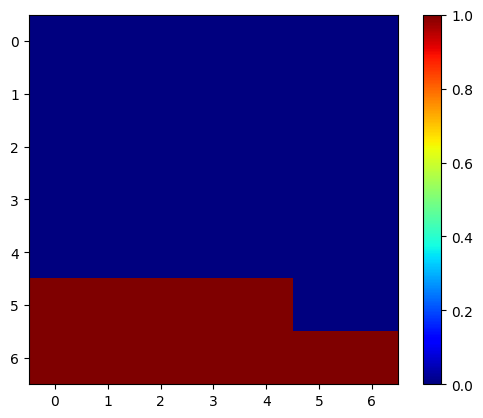

['mountain', 'rock', 'rock']


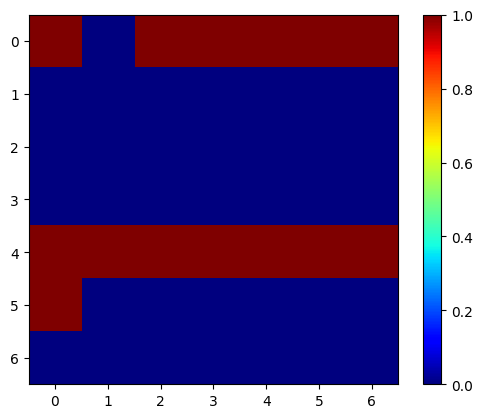

['water']


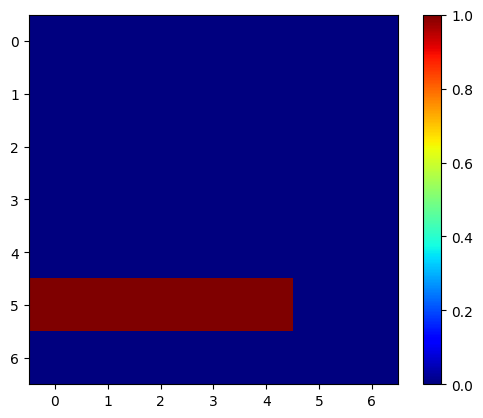

['ocean']


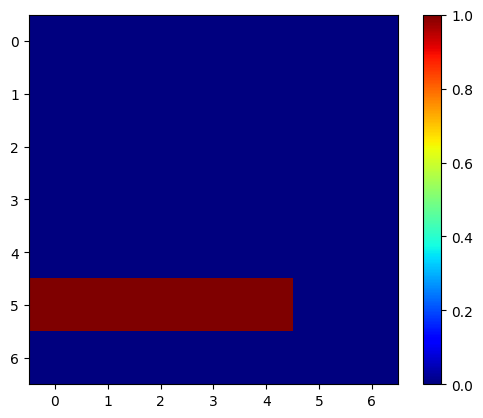

['middle']


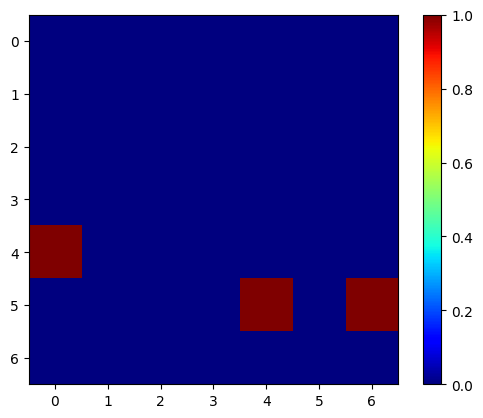

In [ ]:
import cv2
per_layer_positions = deepcopy(per_layer_activations)
for ln in final_results.keys():
    for unit_id, words in final_results[ln].items():
        fm = per_layer_activations[ln][unit_id]
        _, thresh = cv2.threshold(fm, np.max(fm) * .5, np.max(fm), 0)
        thresh = cv2.normalize(thresh, None, 0, 1., cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        lv, rv = thresh.shape[0] // 3, thresh.shape[0] // 3 * 2
        th, bh = lv, rv
        per_layer_positions[ln][unit_id] = get_position(lv, rv, th, bh, thresh)
        print(final_results[ln][unit_id])
        plt.colorbar(plt.imshow(thresh, cmap='jet'))
        plt.show()

In [ ]:
explanation = list()
explanation.append("The model's decision is")
explanation.append(categories[top5_catid[0]])
explanation.append('because it discovered')
for ln in final_results.keys():
    for unit_id in final_results[ln].keys():
        if len(final_results[ln][unit_id]) > 1:
            for word in final_results[ln][unit_id]:
                explanation.append(word)
                explanation.append('and')
            del explanation[-1]
        else:
            explanation.append(final_results[ln][unit_id][0])
        explanation.append(f'at the')
        if len(per_layer_positions[ln][unit_id]) > 1:
            for pos in per_layer_positions[ln][unit_id]:
                explanation.append(pos)
                explanation.append(',')
            del explanation[-1]
            del explanation[-2]
            explanation.insert(-1, 'and the')
        else:
            explanation.append(per_layer_positions[ln][unit_id][0])
        explanation.append('of the image')
        explanation.append(f'({ln} neuron number {unit_id})')
        if len(final_results[ln].keys()) > 1:
            explanation.append(', \n')
if ',' in explanation[-1]: 
    del explanation[-1]
explanation.append('.')
print(' '.join(explanation))
        

The model's decision is lakeside because it discovered water at the left , right and the bottom of the image (layer4 neuron number 510) , 
 mountain and rock and rock at the left , right , top and the bottom of the image (layer4 neuron number 250) , 
 water at the left , right and the bottom of the image (layer4 neuron number 480) , 
 ocean at the left , right and the bottom of the image (layer4 neuron number 128) , 
 middle at the left , right and the bottom of the image (layer4 neuron number 154) .


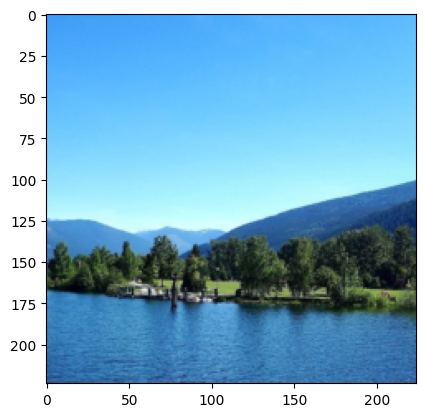

In [ ]:
plt.imshow(image_center_resized)
plt.show()

In [ ]:
def get_activation(layer, input_tensor):
    activations = []

    def hook(module, input, output):
        activations.append(output)

    handle = layer.register_forward_hook(hook)
    model(input_tensor)
    handle.remove()

    return activations[0]

In [ ]:
from typing import List
def associate_channels(input_batch: torch.Tensor, 
                       prev_layer: torch.nn.modules.Conv2d, 
                       prev_out_channels: int,
                       curr_layer: torch.nn.modules.Conv2d, 
                       target_ch_id: int) -> List[int]:
    with torch.no_grad():
        # Get activations of both layers given an input_batch
        activations_curr = get_activation(curr_layer, input_batch)
        activations_curr = activations_curr[:,target_ch_id,:,:]
        activations_prev = get_activation(prev_layer, input_batch)
        
        # Initialize empty placeholder for contributions
        contributions = torch.empty(size=(prev_out_channels,), 
                                    device=input_batch.device)
        
        # Iterate through the channels in the prev_layer
        for ch_id in range(prev_out_channels):
            # Zero out one channel in prev_layer activation tensor
            zeroed_activations_prev = activations_prev.clone()
            zeroed_activations_prev[:,ch_id,:,:] = 0.
                    
            # Compute activation of curr_layer given zeroed out prev_layer
            from_zeroed_activations_curr = curr_layer.forward(zeroed_activations_prev)
            from_zeroed_activations_curr = from_zeroed_activations_curr[:,target_ch_id,:,:]
            
            # Compute the channel score by computing the absolute value of
            # difference between the original output and zeroed out output
            diff = torch.abs(activations_curr - from_zeroed_activations_curr)
            contributions[ch_id] = torch.sum(diff)
        
    return contributions


In [ ]:
x = associate_channels(input_batch=input_batch, 
                   prev_layer=model.layer3, 
                   prev_out_channels=256,
                   curr_layer=model.layer4, 
                   target_ch_id=480)

In [ ]:
torch.argsort(x)

tensor([211, 241, 141, 226, 204, 137, 113,  78, 126, 181, 105,  66, 139, 183,
        172,  36,  44, 184,  48, 178,  81, 165,  86, 100, 121, 155,  21, 143,
        127,  17, 223,  62, 198, 157, 195, 131, 189,  35,  76, 255,  43, 203,
        148,  40,   0, 119,  87, 115,  54,  50,  34, 145, 122,  73, 103,  92,
        242, 251, 140, 182, 135,  64,  16, 144, 224, 213, 164,   4, 185, 112,
         67,  11, 128,  58, 216, 175,  77, 214,  49, 212,  70,  91, 120, 250,
        231, 133,  27, 108, 147, 196, 116, 156, 114, 153, 225,  45,  72, 111,
        170,  51,  31,  15,  71,  80, 168, 118, 101, 233, 154, 234, 150,  18,
        190, 208, 192, 201,  53, 134, 222,  29,  63, 123,   5, 167, 188, 205,
        207, 124,  25,  74, 186, 151, 232,  88,  65, 200, 191,  19,  38, 197,
        146, 229, 125, 237,  24, 160,  23,  99, 227, 174, 254, 249, 215, 149,
        221,  82,  32,  39,  47, 102, 236, 240,  95, 171, 246, 218,  37, 179,
         56,  69,  68,  84, 199, 187,   9, 217, 202, 206, 166, 2

<BarContainer object of 256 artists>

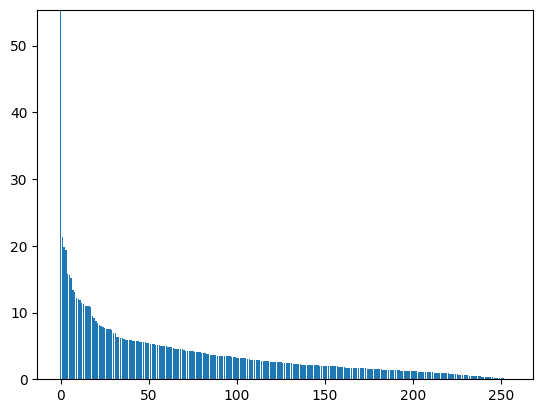

In [ ]:
import matplotlib.pyplot as plt
y = list(x)
y.sort(reverse=True)
plt.ylim(min(y), max(y))
plt.bar(range(len(y)), y)

In [ ]:
y

[tensor(2.5826),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(0.),
 tensor(